# ICS - Travaux Pratiques 12

21.05.25


<font color=grey>_Dans ce 12e TP, nous reviendrons sur les formules d'interpolations de polynômes en utilisant les polynomes de Lagrange. Nous étudierons également les premières méthodes d'intégration numérique vues en cours.._ 

_Note : ne vous sentez pas obligé.e.s de finir la série pendant la séance! Celle-ci est conçue de manière à ce que vous gardiez certains exercices pour vos révisions._ </font>

***

In [1]:
# importation des librairies numpy et matplotlib que nous allons utiliser dans ce notebook  
import numpy as np
import matplotlib.pyplot as plt

## Exercice 1 : interpolation de Lagrange
  

Dans cet exercice, on revient sur la **méthode d'interpolation de Lagrange** qui permet de construire le polynôme $p\in \mathbb{P}_n$ passant par $n+1$ points. On vous demande en particulier... 
1) ...de déterminer l'expression du **polynôme d'interpolation** $p(t)$ passant par :
* les deux points $P_0=(t_0,p_0)$ et $P_1=(t_1,p_1)$ ;
* les trois points $P_0=(t_0,p_0)$, $P_1=(t_1,p_1)$ et $P_2=(t_2,p_2)$.

2) ...de représenter ces deux polynômes en posant $P_0=(1,4)$, $P_1=(4,7)$ et $P_2=(7,-3)$.

Plus précisément, on vous demande 
   * de représenter, dans deux graphiques placés côte à côte dans la même figure de 12 pouces sur 6 pouces, les deux polynômes $p(t)$ obtenus,  ainsi que les points $P_0$, $P_1$ et $P_2$.
   * de représenter également, dans ces mêmes graphiques, en pointillés, les polynômes correspondant à chacun des termes $p_j\varphi_j(t)$, avec $j=0,1$ , respectivement $j=0,1,2$ , intervenant dans la combinaison linéaire définissant les deux polynômes d'interpolation $p$. Indiquez sur la représentation le (ou les) zéro(s) de ces polynômes.
   * d'afficher un titre et une légende de manière à rendre la figure la plus lisible possible.

---
*Note:* the notations of the implementation folow those on the wikipedia page for the method [Wikipedia](https://en.wikipedia.org/wiki/Lagrange_polynomial)

In [2]:
def lagrange_polyfit(x_arr, y_arr):
    '''
    Finds the polynomial fit to a set of points using the Lagrangian interpolation method

    Args:
        x_arr (linear iterable): list of the x values
        y_arr (linear iterable): list of the y values

    Returns:
        L (function): the fitted function
    '''
    # compute lj's
    lj_arr = []
    for j in range(len(x_arr)):
        
        # craft lj function
        def lj(x, j=j, xarr=x_arr): # note that xarr is internal to lj()
            func = 1
            xj = xarr[j]
            
            for k, xk in enumerate(xarr):
                if k == j: # if index is same
                    continue # skip to next j
    
                func *= (x - xk) / (xj - xk) # multiply by next term
            
            return func # returns value of lj(x)
        lj_arr.append(lj)

    # compute weighed sum: L(x)=y1*l1(x) + y2*l2(x) ...
    L = lambda x: sum([yj*lj(x) for yj, lj in zip(y_arr, lj_arr)])
    return L

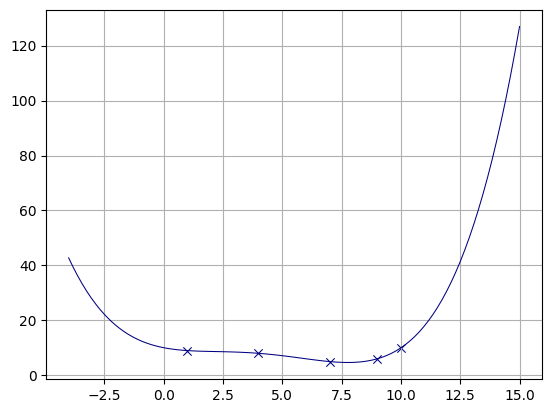

In [3]:
x_arr = [1, 4, 9, 7, 10]
y_arr = [9, 8, 6, 5, 10]

L = lagrange_polyfit(x_arr, y_arr)
plt.plot(x:=np.linspace(min(x_arr)-abs(0.5*max(x_arr)), max(x_arr)+abs(0.5*max(x_arr)), 100), L(x), color='navy', linewidth=0.75)
plt.scatter(x_arr, y_arr, marker='x', color='navy', linewidth=0.75)
plt.grid()
plt.show()

#### Performance of implementation vs scipy

In [4]:
from scipy.interpolate import BarycentricInterpolator, lagrange
import time as tm
import random as rd

n = 50
scp_times = []
custom_times = []
bary_times = []

rng = np.random.default_rng()

for i in range(2, n):
    x = rng.random(i) # random array of unique values
    y = np.log2(x) # any function, has to be injective to guarantee all points will be different
    
    # scipy
    a = tm.time()
    L = lagrange(x, y)
    b = tm.time()
    scp_times.append(b - a)
    
    # custom
    a = tm.time()
    L = lagrange_polyfit(x, y)
    b = tm.time()
    custom_times.append(b - a)

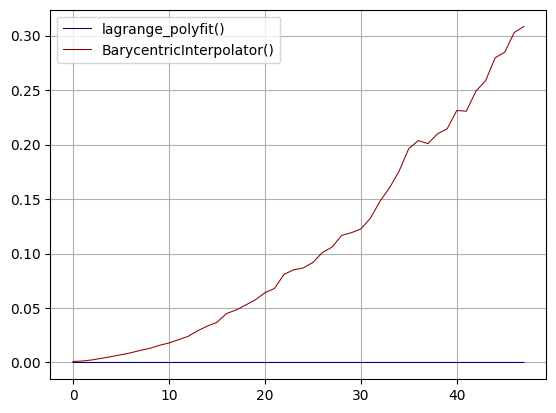

In [5]:
plt.plot(custom_times, color='navy', label='lagrange_polyfit()', linewidth=0.75)
plt.plot(scp_times, color='darkred', label='BarycentricInterpolator()', linewidth=0.75)
plt.legend()
plt.grid()
plt.show()

We can see that our `lagrange_polyfit()` function tops scipy's implementation, this is due to how scipy stores the function as a `numpy.poly1d` object, which allows for operations like integration and derivation to be applied to the polynom, it's usually uninteresting to compute the interpolation fast because it's only a one time use sort of thing, but having a `poly1d` object is way easier to handle and goes faster when computing values of the function (numpy is C based) 

***

## Exercice 2 : Méthodes de quadrature non composites

<font color=grey>**Rappel**

Le principe général des **méthodes non composites** est de remplacer le calcul de l'intégrale définie d'une fonction $f(x)$ entre $a$ et $b$, 
$$
I = \int_{a}^{b}{f(x)dx}\,,
$$
(c'est-à-dire le calcul de l'aire sous la courbe, avec signe) par l'évaluation de la superficie qui se trouve sous la courbe correspondant à un polynôme d'interpolation $p\in \mathbb{P}_n$ passant par $n+1$ points $(x,f(x))$ :
$$
I_n = \int_{a}^{b}{p(x)dx}\,.
$$

Selon la valeur de $n$ (c'est-à-dire selon le nombre de points d'interpolation considérés), on peut donc distinguer :
* les **méthodes du "point de gauche"**, **du "point de droite"**, **du "point milieu"** ou **de Riemann** qui correspondent au cas $n=0$. 
On fait alors passer une **fonction constante** par l'**unique point** choisi : 
    * $(a,f(a))$ (*point de gauche*) , 
    * $(b,f(b))$ (*point de droite*) ,
    * $(\frac{a+b}{2},f(\frac{a+b}{2}))$ (*point milieu*) ,
    * $(\xi,f(\xi))$ (*point choisi au hasard*) ;
* la **méthode du trapèze** qui correspond au cas $n=1$. 
On fait alors passer une **fonction affine** (droite) par les **deux points** choisis :
    * en général, $(a,f(a))$ et $(b,f(b))$ ;
* d'**autres méthodes** (**Simpson**, etc.) que nous aurons l'occasion d'étudier plus tard.</font>


Dans cet exercice, nous allons considérer la fonction réelle d'une variable réelle $f: \mathbb{R}\rightarrow \mathbb{R}$ définie par :

$$
f(x) = (x^2-2x)\exp{(-x)}\,.
$$
Plus précisément, on vous demande de :
* représenter la fonction $f(x)$ sur l'intervalle $[0,6.5]$ ;
* calculer numériquement la valeur approchée des intégrales $I_1 = \int_{0.5}^{4}{f(x)dx}$ et 
$I_2 = \int_{4}^{6}{f(x)dx}$ en utilisant les **méthodes de quadrature non composites** énumérées plus haut (méthodes du *point de gauche*, du *point de droite*, du *point milieu*, de *Riemann* (*point choisi au hasard*) et du *trapèze*). <br>
Pour ce faire, on vous propose de définir une fonction `integration_noncomposite` admettant comme arguments : la fonction `f` à intégrer, les bornes `a` et `b` de l'intervalle d'intégration considéré, ainsi que la `methode` choisie (`gauche`, `droite`, `milieu`, `riemann` ou `trapeze`). <br>
Cette fonction devra afficher un message d'erreur 
    - si $a\ge b$ ;  
    - si la méthode précisée en argument ne fait pas partie des méthodes prises en charge par la fonction. 

  L'implémentation de la méthode de Riemann, doit se faire grâce à la fonction `random.uniform()` du module `random` de Python pour déterminer un point au hasard dans l'intervalle $[a,b]$ (`random.uniform(a,b)`).<br>
Vos résultats devront être affichés clairement à l'aide de quelques instructions `print()`. <br>
Dans le cas de la *méthode du trapèze*, on vous demande de plus de représenter la fonction $f(x)$ en mettant en évidence l'aire calculée à l'aide de la méthode `plt.fill()` qui permet de colorier l'intérieur d'un polygone.
* discuter vos résultats en les comparant entre eux et avec les valeurs exactes obtenues en cherchant la primitive de $f$ :

$$
I_1 \cong -0.1414175573 ~~~~\text{et}~~~~I_2 \cong 0.2038151439\,.
$$

---
**Réponse:** using:
$$\int _{a}^{b}f(x)\,dx\approx {\frac {b-a}{n}}\left({f(a) \over 2}+\sum _{k=1}^{n-1}\left(f\left(a+k{\frac {b-a}{n}}\right)\right)+{f(b) \over 2}\right)$$
For the trapeze method, see [here](https://en.wikipedia.org/wiki/Numerical_integration#Quadrature_rules_based_on_interpolating_functions)

In [24]:
import random as rd

def integrate(f, a, b, n=100000, method='trapeze'):
    '''
    Approximates the value of the integral from a to b of f using one of methods
    '''
    if method == 'left':
        integral = sum(f(k) * (b - a) / n for k in np.linspace(a, b, n))

    elif method == 'right':
        integral = sum(f(k + (b - a) / n) * (b - a) / n for k in np.linspace(a, b, n))
        
    elif method == 'center':
        integral = sum(f(((k + (b - a) / n) + k) / 2) * (b - a) / n for k in np.linspace(a, b, n))

    elif method == 'riemann':
        integral = f(rd.uniform(a, b)) * (b - a)

    elif method == 'trapeze':
        integral = (b - a) / n * (f(a) / 2 + sum(f(a + k * (b - a) / n) for k in range(n)) + f(b) / 2)

    else:
        raise Exception("'method' must be one of 'left', 'right', 'center', 'riemann' and 'trapeze'")
        
    return integral

In [26]:
for method in ['left', 'right', 'center', 'riemann', 'trapeze']:
    print(f"Integral {method}: {integrate(lambda x: (x**2-2*x)*np.exp(-x), 4, 6, method=method)}")

Integral left: 0.20381516586001863
Integral right: 0.20381342516236506
Integral center: 0.20381429551109528
Integral riemann: 0.2878694281336094
Integral trapeze: 0.20381807436204252


***

## Exercice 3 :  Méthodes de quadrature composites


<font color=grey>**Rappel** 

Sur un intervalle $[a,b]$ grand, il est possible d'appliquer une méthode de quadrature non composite telle que décrite ci-dessus en prenant soin de considérer un polynôme $p\in \mathbb{P}_n$ avec $n$ grand (de manière à interpoler le mieux possible la fonction $f(x)$ sur l'intervalle). Toutefois, il est souvent préférable d'appliquer une **méthode de quadrature composite** : on divise l'intervalle $[a,b]$ en un certain nombre de sous-intervalles (autrement dit, on crée une partition de $[a,b]$) dans lesquels on interpole grâce à des polynômes $p\in \mathbb{P}_n$ avec $n$ petit. </font>

Dans cet exercice, on vous propose d'affiner le calcul des intégrales définies $I_1$ et $I_2$ déjà abordé à l'exercice 2. Plus précisément, on vous demande de :
* définir une fonction `integration_composite` admettant comme arguments : la fonction `f` à intégrer, les bornes `a` et `b` de l'intervalle d'intégration, le nombre `n` de sous-intervalles de la partition (que l'on supposera régulière) considérée, ainsi que la méthode (unique) choisie (`gauche`, `droite`, `milieu`, `riemann` ou `trapeze`) pour intégrer chacun des sous-intervalles. Cette fonction devra utiliser la fonction `integration_noncomposite` de l'exercice 2 ;
* calculer les intégrales définies $I_1$ et $I_2$ à l'aide des différentes méthodes ;
* faire varier le nombre de sous-intervalles (c'est-à-dire de modifier la **finesse de la partition**) et d'observer l'incidence sur les valeurs obtenues ;
* deviner une manière d'estimer l'erreur commise dans le calcul.

---
**Réponse:** ce qui est demandé ici a déjà été fait dans l'exercice 2, au lieu de cela, on va essayer d'implémenter une autre méthode d'intégration en calculant une approximation polynomiale sur chaque sous-intervalle $I$, puis en intégrant <u>algèbriquement</u> chaque polynôme 

#### With sympy symbollic polynomial itegration 

In [8]:
import sympy as sp

def composite_sympy(f, a, b, n, degree=4):
    # create sub intervals
    array = np.linspace(a, b, n).repeat(2)[1:-1].reshape(-1, 2)
    x = sp.Symbol('x') # initialize x
    A = 0

    # approximate polynomials over `degree` points on each subintervals
    for subint in array:
        subarr = np.linspace(subint[0], subint[1], degree)
        polynom = sp.interpolate(list(zip(subarr, f(subarr))), x)
        # symbolic integration of the polynoms over the intervals
        primitive = sp.integrate(polynom, x)
        area = primitive.subs(x, subint[1]) - primitive.subs(x, subint[0])
        A += area

    return float(A)

In [9]:
composite_sympy(lambda x: (x**2-2*x)*np.exp(-x), 4, 6, n=50)

0.20381514391622124

#### By applying pure Lagrange and custom numerical integration

##### Lagrange adapted to return the coefficients of the fitting polynomial

*Note: the four fuctions defined to compute the coeffs were made in an AI-assisted way from a given mathematical method, see [here](https://math.stackexchange.com/questions/944465/coefficients-of-lagrange-polynomials)*

In [10]:
def poly_mul(p1, p2):
    """Multiply two polynomials represented as coefficient lists (ascending order)."""
    result = [0] * (len(p1) + len(p2) - 1)
    for i, a in enumerate(p1):
        for j, b in enumerate(p2):
            result[i + j] += a * b
    return result

def poly_add(p1, p2):
    """Add two polynomials represented as coefficient lists (ascending order)."""
    length = max(len(p1), len(p2))
    result = [0] * length
    for i in range(length):
        coeff1 = p1[i] if i < len(p1) else 0
        coeff2 = p2[i] if i < len(p2) else 0
        result[i] = coeff1 + coeff2
    return result

def poly_from_roots(roots):
    """Return coefficients of polynomial with given roots (ascending order)."""
    poly = [1]
    for root in roots:
        poly = poly_mul(poly, [-root, 1])  # (x - root)
    return poly

def lagrange_coeffs(x, y):
    """
    Compute Lagrange interpolation polynomial coefficients (ascending order)
    for points (x, y) using barycentric-like construction.
    """
    n = len(x)
    coeffs = [0] * n

    for j in range(n):
        # Compute basis polynomial Lj(x)
        roots = [x[k] for k in range(n) if k != j]
        basis_poly = poly_from_roots(roots)

        # Compute denominator = product of (x_j - x_k) for k != j
        denom = 1
        for root in roots:
            denom *= (x[j] - root)

        # Scale the basis polynomial by y[j] / denom
        scaled_basis = [(y[j] * coeff) / denom for coeff in basis_poly]

        # Add to total coefficients
        coeffs = poly_add(coeffs, scaled_basis)

    return coeffs

##### Function to compute the polynomial integrals

In [11]:
def composite(f, a, b, n, degree=4):
    array = np.linspace(a, b, n).repeat(2)[1:-1].reshape(-1, 2)
    poly = lambda x, coeff: sum(j*x**i for i, j in enumerate(coeff))
    A = 0
    
    for subint in array:
        subarr = np.linspace(subint[0], subint[1], degree)
        coeffs = lagrange_coeffs(subarr, f(subarr))

        # compute polynomial integral
        integrated_coeffs = [0]
        for deg, a in enumerate(coeffs):
            integrated_coeffs.append(a / (deg + 1))
        A += poly(subint[1], integrated_coeffs) - poly(subint[0], integrated_coeffs)

    return float(A)

In [12]:
composite(lambda x: (x**2-2*x)*np.exp(-x), 4, 6, n=50)

0.20381514446827342

#### Computing error using Richardson extrapolation

*Note: see [here](https://en.wikipedia.org/wiki/Richardson_extrapolation) for more details*

In [28]:
def error(approx_function, f, a, b, n):
    th = approx_function(f=f, a=a, b=b, n=n)
    te = (4 * approx_function(f, a, b, n // 2) - th) / 3
    return abs(th - te)

#### Convergence comparison

In [30]:
n = 30
f = lambda x: (x**2-2*x)*np.exp(-x)

integrate_array = [error(integrate, f, 4, 6, i) for i in range(2, n)]
sympy_array = [error(composite_sympy, f, 4, 6, i) for i in range(2, n)]
composite_array = [error(composite, f, 4, 6, i) for i in range(2, n)]

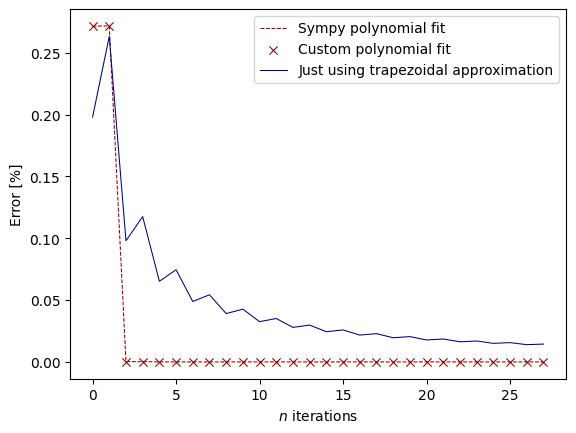

In [34]:
plt.plot(sympy_array, color='darkred', linewidth=0.75, linestyle='--', label='Sympy polynomial fit')
plt.scatter(range(0, n-2), composite_array, color='darkred', linewidth=0.75, marker='x', label='Custom polynomial fit')
plt.plot(integrate_array, color='navy', linewidth=0.75, label='Just using trapezoidal approximation')
plt.legend()
plt.xlabel(r'$n$ iterations')
plt.ylabel(r"Error [%]")
plt.show()